# REINFORCE on GridWorld

In [63]:
from typing import TypeAlias, Callable
from enum import Enum
from collections import defaultdict
import random

import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import trange

plt.rcParams['text.usetex'] = True

## Defining the Environment

In [64]:
State: TypeAlias = tuple[int, int]
ActionValue: TypeAlias = tuple[int, int]

class Action(Enum):
    AU = (-1, 0)
    AD = (1, 0)
    AL = (0, -1)
    AR = (0, 1)

val_to_enum: dict[ActionValue, Action] = {a.value: a for a in Action}
enum_to_char: dict[Action, str] = {
    Action.AU: "↑",
    Action.AR: "→",
    Action.AL: "←",
    Action.AD: "↓",
}
enum_to_idx: dict[Action, int] = {
    Action.AU: 0,
    Action.AR: 1,
    Action.AL: 2,
    Action.AD: 3,
}
idx_to_enum = [Action.AU, Action.AR, Action.AL, Action.AD]

left_rotate: Callable[[Action], Action] = lambda a: val_to_enum[(-a.value[1], a.value[0])]
right_rotate: Callable[[Action], Action] = lambda a: val_to_enum[(a.value[1], -a.value[0])]

# Constants
MIN_R, MIN_C = 0, 0
MAX_R, MAX_C = 4, 4
FORBIDDEN: set[State] = { (2, 1), (2, 2), (2, 3), (3, 2) }
GOAL = (4, 4)
MAX_STEP = 5000
DISCOUNT_RATE = 0.925

def take_action(s: State, a: Action) -> State:
    r = s[0] + a.value[0]
    c = s[1] + a.value[1]

    if r < MIN_R:
        r = MIN_R
    if r > MAX_R:
        r = MAX_R

    if c < MIN_C:
        c = MIN_C
    if c > MAX_C:
        c = MAX_C

    if (r, c) in FORBIDDEN:
        return s

    return (r, c)


def transition(s: State, a: Action) -> list[tuple[State, float]]:
    p: dict[State, float] = defaultdict(float)
    p[take_action(s, a)] += 0.7
    p[take_action(s, right_rotate(a))] += 0.12
    p[take_action(s, left_rotate(a))] += 0.12
    p[s] += 0.06

    return list(p.items())

def reward(s_new: State) -> float:
    if s_new == GOAL:
        return 10
    if s_new == (0, 3) or s_new == (4, 1):
        return -8
    return -0.05

In [65]:
def generate_episode(policy: torch.Tensor):
    # random initial state that is not forbidden
    while True:
        x = random.randint(MIN_C, MAX_C)
        y = random.randint(MIN_R, MAX_R)
        s = (y, x)
        if s not in FORBIDDEN and s != GOAL:
            break

    steps: list[tuple[State, Action, float]] = []

    for _ in range(MAX_STEP):
        if s == GOAL: break
        action_probs = policy[*s]
        action = idx_to_enum[torch.multinomial(action_probs, num_samples=1).item()]
        state_prob = transition(s, action)
        s_new = random.choices(*list(zip(*state_prob)))[0]
        r = reward(s_new)
        steps.append((s, action, r))
        s = s_new

    for i in range(len(steps)-1, 0, -1):
        s, a, r = steps[i-1]
        steps[i-1] = (s, a, r + DISCOUNT_RATE * steps[i][2])

    return steps

## REINFORCE Algorithm with Baseline

In [66]:
def reinforce_baseline(alpha_w: float, alpha_theta: float):
    policy_weights = torch.empty(MAX_R+1, MAX_C+1, len(Action))
    policy_weights.uniform_()
    policy_weights.requires_grad_()
    value_weights = torch.empty(MAX_R+1, MAX_C+1)
    value_weights.uniform_()

    returns: list[float] = []

    MAX_ITER = 5000
    for _ in trange(MAX_ITER):
        with torch.no_grad():
            current_policy = F.softmax(policy_weights, dim=-1)
        steps = generate_episode(current_policy)
        returns.append(steps[0][2])

        for t, (state, action, G) in enumerate(steps):
            delta = G - value_weights[*state]

            # since value approximation is a look up table, gradient = 1
            value_weights[*state] += alpha_w * delta

            policy = F.softmax(policy_weights[*state], dim=-1)
            log_prob = torch.log(policy[enum_to_idx[action]])
            log_prob.backward()

            with torch.no_grad():
                policy_weights += alpha_theta * DISCOUNT_RATE**t * delta * policy_weights.grad

            policy_weights.grad.zero_()
        
    return policy_weights, value_weights, returns

## Experiment

In [67]:
random.seed(0)
torch.manual_seed(2)
policy, value, rs = reinforce_baseline(0.1, 0.1)
max_val, max_idx = torch.max(F.softmax(policy, dim=-1), dim=-1)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:13<00:00, 372.91it/s]


In [68]:
for r in range(MIN_R, MAX_R+1):
    for c in range(MIN_C, MAX_C+1):
        val = max_val[r][c].item()
        idx = max_idx[r][c].item()
        print(
            "G" if (r, c) == GOAL
            else " " if (r, c) in FORBIDDEN
            else enum_to_char[idx_to_enum[idx]],
            end=" "
        )
        print(" " * 7 if (r, c) == GOAL or (r, c) in FORBIDDEN else f"({val:3.3f})", end=" ")
    print()
print()

value = value.numpy()
for r in range(MIN_R, MAX_R+1):
    for c in range(MIN_C, MAX_C+1):
        idx = max_idx[r][c].item()
        print(
            " " * 8 if (r, c) == GOAL or (r, c) in FORBIDDEN
            else f"{value[r,c]:8.4f}",
            end=" "
        )
    print()

→ (0.892) ↓ (0.986) ← (0.993) ↓ (0.997) ↓ (0.990) 
→ (0.981) → (0.999) ↓ (0.998) → (1.000) ↓ (0.997) 
↑ (0.988)                               ↓ (0.996) 
↑ (0.982) ↑ (0.997)           → (0.958) ↓ (0.997) 
↑ (0.997) → (0.999) → (0.999) → (0.994) G         

  1.6268   1.0557   1.4463   4.8734   5.8304 
  0.8503   2.7377   4.1029   6.3493   7.4430 
  0.8950                              8.3550 
  0.0352   0.2392            8.8518   9.6181 
 -0.2220   5.8419   8.7717   9.7901          


## Experiment with Hyperparameters

In [69]:
hyperparams = [
    (0.1, 0.1),
    (0.05, 0.1),
    (0.1, 0.05),
    (0.05, 0.05),
]

results = []

for alpha_w, alpha_theta in hyperparams:
    _, _, rs = reinforce_baseline(alpha_w=alpha_w, alpha_theta=alpha_theta)
    results.append(np.array(rs))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:08<00:00, 582.30it/s]


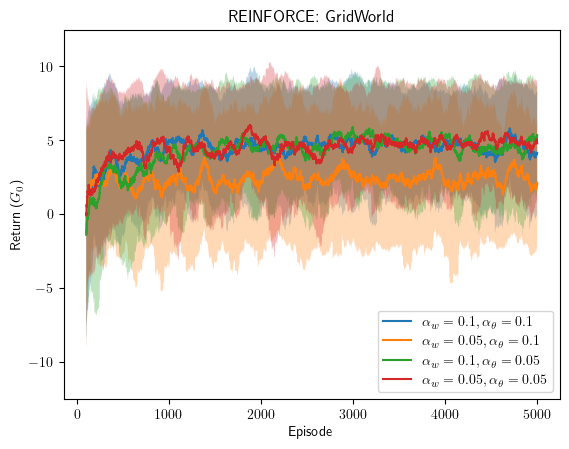

In [72]:
window = 100  # size of smoothing window

for (alpha_w, alpha_theta), returns in zip(hyperparams, results):
    means = np.convolve(returns, np.ones(window)/window, mode='valid')
    stds = np.array([returns[i-window:i].std() for i in range(window, len(returns)+1)])
    episodes = np.arange(window, len(returns)+1)
    
    plt.plot(episodes, means, label=f"$\\alpha_w = {alpha_w}, \\alpha_\\theta = {alpha_theta}$")
    plt.fill_between(episodes, means-stds, means+stds, alpha=0.3)

plt.xlabel("Episode")
plt.ylabel("Return ($G_0$)")
plt.ylim(-12.5, 12.5)
plt.title("REINFORCE: GridWorld")
plt.legend()
plt.savefig("plot-gridworld.png", dpi=300)
plt.show()